In [31]:
# === A. TRAIN & SAVE ONLY =====================================================
import os, time, random, numpy as np
from node2vecs.torch.torch_node2vec import TorchNode2Vec  # your library

OUTDIR = "emb_ckpts_v3"   # change if you like
os.makedirs(OUTDIR, exist_ok=True)

# Two configs we compare
# CONFIGS = [
#     ("Euclid-Dot", dict(manifold=False, metric="dot")),  # angles + lengths
#     ("Sphere-Dot", dict(manifold=True,  metric="dot")),  # angles-only (dot ≡ cos on unit sphere)
# ]

# REPLACE your CONFIGS with this (in the TRAIN & SAVE cell)
CONFIGS = [
    # angles + lengths (leave defaults)
    ("Euclid-Dot", dict(manifold=False, metric="dot", 
                            train_overrides=dict(
                                            temperature = 1.0
                                                )
                       )
    ),
    # angles-only (needs more steps / larger LR to learn well)
    ("Sphere-Dot", dict(
        manifold=True, metric="dot",
        train_overrides=dict(
            epochs=1,        # was 6
            lr=3e-3,          # was 1e-3
            num_walks=10,     # was 10
            walk_length=80,    # was 40
            negative=10,     # uncomment ONLY if Sphere still ~chance
            temperature = 10.0
        )
    )),
]


def set_all_seeds(seed=0):
    import torch
    np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# --------- Harder SBMs (reduce ceiling effects) ----------
def sbm_balanced(n=2000, p_in=0.040, p_out=0.039, seed=11):
    rng = np.random.RandomState(seed)
    n2 = n//2; A = np.zeros((n,n), np.float32)
    for (i0,i1) in [(0,n2),(n2,n)]:
        M = rng.rand(i1-i0, i1-i0) < p_in
        np.fill_diagonal(M, 0); A[i0:i1, i0:i1] = M
    C = rng.rand(n2, n-n2) < p_out
    A[:n2, n2:] = C; A[n2:, :n2] = C.T
    y = np.r_[np.zeros(n2,int), np.ones(n-n2,int)]
    return A, y

def sbm_hetero(n=2000, p_in_A=0.055, p_in_B=0.030, p_out=0.04, seed=12):
    rng = np.random.RandomState(seed)
    n2 = n//2; A = np.zeros((n,n), np.float32)
    MA = rng.rand(n2, n2) < p_in_A; np.fill_diagonal(MA, 0); A[:n2,:n2] = MA
    MB = rng.rand(n-n2, n-n2) < p_in_B; np.fill_diagonal(MB, 0); A[n2:,n2:] = MB
    C = rng.rand(n2, n-n2) < p_out
    A[:n2, n2:] = C; A[n2:, :n2] = C.T
    y = np.r_[np.zeros(n2,int), np.ones(n-n2,int)]
    return A, y

# --------- Training wrappers (save BOTH U & V) -----------
def run_one(A, manifold, metric, dim=128, epochs=1, seed=0, device="cpu",
            window=10, num_walks=10, p=1.0, q=1.0, walk_length=80,
            batch_size=256*4, lr=1e-3, miniters=200, num_workers=4,negative=5, temperature = None):
    import torch
    set_all_seeds(seed)
    n2v = TorchNode2Vec(
        device=device,
        batch_size=batch_size,
        buffer_size=100000,
        negative = negative,
        context_window_type="double",
        miniters=miniters,
        num_workers=num_workers,
        alpha=lr,
        learn_outvec=True,
        similarity_metric=metric,   # "dot"
        manifold=manifold,          # True => Sphere
        window=window,
        num_walks=num_walks,
        epochs=epochs,
        p=p, q=q,
        walk_length=walk_length,
        temperature = temperature
    )
    n2v.fit(A)
    n2v.update_embedding(dim)              # trains & fills n2v.in_vec / n2v.out_vec
    U = np.asarray(n2v.in_vec,  dtype=np.float32)
    V = np.asarray(n2v.out_vec, dtype=np.float32)
    return U, V

def save_uv(U, V, path_npz):
    np.savez(path_npz, U=U, V=V)

def train_and_save_embeddings(A, dataset_name, seeds=range(1), dim=128, epochs=1, device="cpu"):
    total = len(CONFIGS) * len(list(seeds))
    print(f"[TRAIN] Dataset={dataset_name} | {total} runs ({len(CONFIGS)} configs × {len(list(seeds))} seeds)")
    for tag, cfg in CONFIGS:
        for s in seeds:
            fname = os.path.join(OUTDIR, f"emb_{dataset_name}_{tag}_seed{s}.npz")
            if os.path.exists(fname):
                print(f"[SKIP]  {dataset_name} | {tag} | seed={s} → exists")
                continue
            t0 = time.time()
            print(f"[RUN ]  {dataset_name} | {tag} | seed={s} ...", end="", flush=True)
            # U, V = run_one(A, manifold=cfg["manifold"], metric=cfg["metric"],
            #                dim=dim, epochs=epochs, seed=s, device=device)

            # inside train_and_save_embeddings(...) just before saving
            over = cfg.get("train_overrides", {})
            
            # build defaults, then let overrides replace keys
            kw = dict(
                dim=dim,
                epochs=epochs,
                lr=1e-3,
                num_walks=10,
                walk_length=80,
                negative=5,
                seed=s,
                device=device,
            )
            kw.update(over)  # overrides (e.g., epochs=20, lr=3e-3, ...)
            
            U, V = run_one(
                A,
                manifold=cfg["manifold"],
                metric=cfg["metric"],
                **kw
            )

            save_uv(U, V, fname)
            print(f" saved {os.path.basename(fname)} in {time.time()-t0:.1f}s")

# --------- Generate & TRAIN ONLY ----------
A1, y1 = sbm_balanced()
A2, y2 = sbm_hetero()

train_and_save_embeddings(A1, "SBM-homo-harder",   seeds=range(1), dim=128, epochs=1, device="cuda:0")
train_and_save_embeddings(A2, "SBM-hetero-harder", seeds=range(1), dim=128, epochs=1, device="cuda:0")
print("[DONE] training stage — embeddings saved to", OUTDIR)


[TRAIN] Dataset=SBM-homo-harder | 2 runs (2 configs × 1 seeds)
[RUN ]  SBM-homo-harder | Euclid-Dot | seed=0 ...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:25<00:00, 60.26it/s, loss=2.7]


 saved emb_SBM-homo-harder_Euclid-Dot_seed0.npz in 29.0s
[RUN ]  SBM-homo-harder | Sphere-Dot | seed=0 ...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:30<00:00, 50.94it/s, loss=3.48]


 saved emb_SBM-homo-harder_Sphere-Dot_seed0.npz in 36.6s
[TRAIN] Dataset=SBM-hetero-harder | 2 runs (2 configs × 1 seeds)
[RUN ]  SBM-hetero-harder | Euclid-Dot | seed=0 ...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:25<00:00, 61.31it/s, loss=2.7]


 saved emb_SBM-hetero-harder_Euclid-Dot_seed0.npz in 28.5s
[RUN ]  SBM-hetero-harder | Sphere-Dot | seed=0 ...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 52.29it/s, loss=3.49]


 saved emb_SBM-hetero-harder_Sphere-Dot_seed0.npz in 35.8s
[DONE] training stage — embeddings saved to emb_ckpts_v3


/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


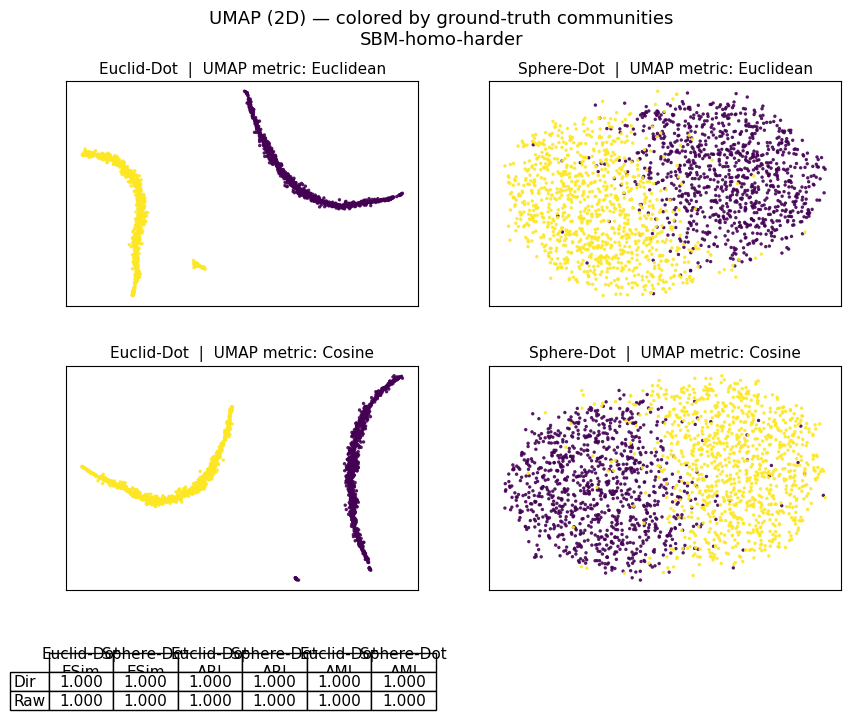

/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


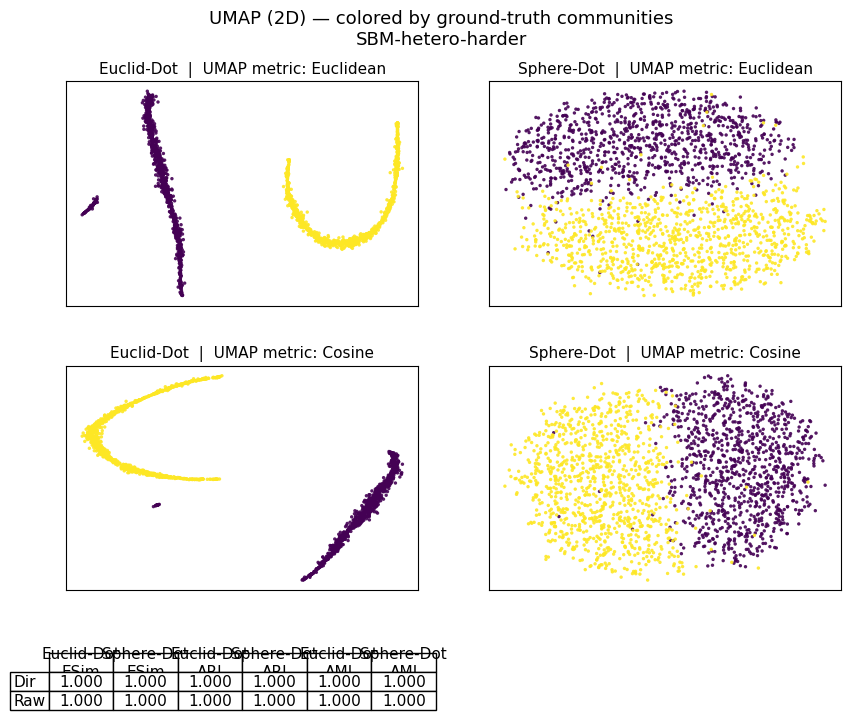

,Space,Config,ARI,AMI,ESim
0,Dir,Euclid-Dot,1.0,1.0,1.0
1,Dir,Sphere-Dot,1.0,1.0,1.0
2,Raw,Euclid-Dot,1.0,1.0,1.0
3,Raw,Sphere-Dot,1.0,1.0,1.0


,Space,Config,ARI,AMI,ESim
0,Dir,Euclid-Dot,1.0,1.0,1.0
1,Dir,Sphere-Dot,1.0,1.0,1.0
2,Raw,Euclid-Dot,1.0,1.0,1.0
3,Raw,Sphere-Dot,1.0,1.0,1.0


In [33]:
# === UMAP visualizations (run BEFORE probes) =================================
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import umap
# --- A) Helpers: UMAP, KMeans, ESim, loaders ---

import os, numpy as np, scipy.sparse as sp, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ESim (your function, verbatim with tiny guards)
def calc_esim(y_true, y_pred):
    ylab, y = np.unique(y_true, return_inverse=True)
    plab, p = np.unique(y_pred, return_inverse=True)
    K = max(len(ylab), len(plab)); N = len(y)
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(N), y)), shape=(N, K))
    UB = sp.csr_matrix((np.ones_like(p), (np.arange(N), p)), shape=(N, K))
    nA = np.array(UA.sum(axis=0)).ravel(); nB = np.array(UB.sum(axis=0)).ravel()
    nAB = (UA.T @ UB).toarray(); nAB_rand = np.outer(nA, nB) / max(N,1)
    Q = 1.0 / np.maximum(np.maximum(nA[:,None], 1), np.maximum(1, nB[None,:]))
    S = float(np.sum(Q * (nAB**2)) / max(N,1))
    Srand = float(np.sum(Q * (nAB_rand**2)) / max(N,1))
    return (S - Srand) / (1 - Srand + 1e-12)

# # Try to import UMAP cleanly
# import umap

# OUTDIR = "emb_ckpts_v2"  # must match your training cell
# DATASETS = {
#     "SBM-homo-harder": None,
#     "SBM-hetero-harder": None,
# }
# CONFIGS = ["Euclid-Dot", "Sphere-Dot"]

# # (Re)build labels y to color the scatter (same generators/params used in training)
# def sbm_balanced(n=2000, p_in=0.060, p_out=0.012, seed=11):
#     rng = np.random.RandomState(seed)
#     n2 = n//2
#     y = np.r_[np.zeros(n2,int), np.ones(n-n2,int)]
#     return y

# def sbm_hetero(n=2000, p_in_A=0.090, p_in_B=0.050, p_out=0.012, seed=12):
#     rng = np.random.RandomState(seed)
#     n2 = n//2
#     y = np.r_[np.zeros(n2,int), np.ones(n-n2,int)]
#     return y

# Y_CACHE = {
#     "SBM-homo-harder": sbm_balanced(),
#     "SBM-hetero-harder": sbm_hetero(),
# }
# === UMAP visualizations (2D only) + KMeans/ESim in HIGH-D ====================
import os, numpy as np, scipy.sparse as sp, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import normalize
import umap

OUTDIR = "emb_ckpts_v2"                 # must match training
CONFIG_ORDER = ["Euclid-Dot", "Sphere-Dot"]

# --- ESim (unchanged) ---
def calc_esim(y_true, y_pred):
    ylab, y = np.unique(y_true, return_inverse=True)
    plab, p = np.unique(y_pred, return_inverse=True)
    K = max(len(ylab), len(plab)); N = len(y)
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(N), y)), shape=(N, K))
    UB = sp.csr_matrix((np.ones_like(p), (np.arange(N), p)), shape=(N, K))
    nA = np.array(UA.sum(axis=0)).ravel(); nB = np.array(UB.sum(axis=0)).ravel()
    nAB = (UA.T @ UB).toarray(); nAB_rand = np.outer(nA, nB) / max(N,1)
    Q = 1.0 / np.maximum(np.maximum(nA[:,None], 1), np.maximum(1, nB[None,:]))
    S = float(np.sum(Q * (nAB**2)) / max(N,1))
    Srand = float(np.sum(Q * (nAB_rand**2)) / max(N,1))
    return (S - Srand) / (1 - Srand + 1e-12)

# --- I/O helpers ---
def load_U(dataset_name, config, seed=0):
    d = np.load(os.path.join(OUTDIR, f"emb_{dataset_name}_{config}_seed{seed}.npz"))
    return d["U"]

def to_unit_rows(X):
    r = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.clip(r, 1e-12, None), r.squeeze(-1)

# --- HIGH-D clustering probes (Raw & Dir) ---
def metrics_highD(U, y, k=None, seed=0):
    k = k or len(np.unique(y))
    # Raw space
    lab_raw = KMeans(n_clusters=k, n_init=20, random_state=seed).fit_predict(U)
    ari_raw = adjusted_rand_score(y, lab_raw)
    ami_raw = adjusted_mutual_info_score(y, lab_raw)
    esim_raw = calc_esim(y, lab_raw)
    # Dir (unit vectors)
    Udir, _ = to_unit_rows(U)
    lab_dir = KMeans(n_clusters=k, n_init=20, random_state=seed).fit_predict(Udir)
    ari_dir = adjusted_rand_score(y, lab_dir)
    ami_dir = adjusted_mutual_info_score(y, lab_dir)
    esim_dir = calc_esim(y, lab_dir)
    return dict(ARI_raw=ari_raw, AMI_raw=ami_raw, ESim_raw=esim_raw,
                ARI_dir=ari_dir, AMI_dir=ami_dir, ESim_dir=esim_dir)

# --- UMAP (2D) for visualization only ---
def umap_2d(X, metric="euclidean", n_neighbors=20, min_dist=0.05, seed=42):
    Xp = normalize(X) if metric == "cosine" else X
    reducer = umap.UMAP(
        n_neighbors=n_neighbors, min_dist=min_dist, n_components=2,
        metric=metric, init="random", n_epochs=100
    )
    return reducer.fit_transform(Xp)

def plot_umaps_with_hd_table(dataset_name, y, seed=0,
                             n_neighbors=20, min_dist=0.05, pointsize=6,
                             title_font=12, subtitle_font=11, cell_font=11):
    rows = []
    # 2 rows of UMAPs (euclid, cosine) × #configs, plus a bottom table
    fig, axes = plt.subplots(3, len(CONFIG_ORDER), figsize=(5*len(CONFIG_ORDER), 8),
                             gridspec_kw={"height_ratios":[1,1,0.28]}, squeeze=False)
    fig.suptitle(f"UMAP (2D) — colored by ground-truth communities\n{dataset_name}",
                 y=0.99, fontsize=title_font+1)

    for j, cfg in enumerate(CONFIG_ORDER):
        U = load_U(dataset_name, cfg, seed=seed)

        # --- UMAP displays (no clustering in 2D) ---
        Z_e = umap_2d(U, metric="euclidean", n_neighbors=n_neighbors, min_dist=min_dist, seed=seed)
        ax = axes[0, j]
        ax.scatter(Z_e[:,0], Z_e[:,1], c=y, s=pointsize, cmap="viridis", alpha=0.9, linewidths=0)
        ax.set_title(f"{cfg}  |  UMAP metric: Euclidean", fontsize=subtitle_font)
        ax.set_xticks([]); ax.set_yticks([])

        Z_c = umap_2d(U, metric="cosine", n_neighbors=n_neighbors, min_dist=min_dist, seed=seed)
        ax = axes[1, j]
        ax.scatter(Z_c[:,0], Z_c[:,1], c=y, s=pointsize, cmap="viridis", alpha=0.9, linewidths=0)
        ax.set_title(f"{cfg}  |  UMAP metric: Cosine", fontsize=subtitle_font)
        ax.set_xticks([]); ax.set_yticks([])

        # --- HIGH-D KMeans + ESim/ARI/AMI (this is what we report) ---
        m = metrics_highD(U, y, k=len(np.unique(y)), seed=seed)
        rows.append(dict(Config=cfg, Space="Raw",  ARI=m["ARI_raw"], AMI=m["AMI_raw"], ESim=m["ESim_raw"]))
        rows.append(dict(Config=cfg, Space="Dir",  ARI=m["ARI_dir"], AMI=m["AMI_dir"], ESim=m["ESim_dir"]))

    # bottom table
    df_tbl = pd.DataFrame(rows).set_index(["Space","Config"]).sort_index()
    ax_tbl = axes[2, 0]; ax_tbl.axis("off")
    for jj in range(1, len(CONFIG_ORDER)): axes[2, jj].axis("off")

    # two small tables side-by-side (ESim and ARI/AMI), or one wide table; here: one wide with three metrics
    pivot = df_tbl.unstack("Config")  # rows: Space; columns: metric × Config
    # build a readable table with 3 blocks (ESim | ARI | AMI)
    blocks = []
    for metric in ["ESim","ARI","AMI"]:
        blk = pivot[metric]
        blk.columns = [f"{c}\n{metric}" for c in blk.columns]
        blocks.append(blk)
    show = pd.concat(blocks, axis=1)
    celltext = [[f"{v:.3f}" for v in show.loc[row]] for row in show.index]
    table = ax_tbl.table(
        cellText=celltext,
        rowLabels=list(show.index),
        colLabels=list(show.columns),
        loc="center",
        cellLoc="center"
    )
    table.auto_set_font_size(False); table.set_fontsize(cell_font)
    table.scale(1.1, 1.2)

    plt.subplots_adjust(top=0.90, hspace=0.35)
    plt.show()
    return df_tbl.reset_index()

# ---- call BEFORE probes ----
tbl_h = plot_umaps_with_hd_table("SBM-homo-harder",   y1, seed=0)
tbl_x = plot_umaps_with_hd_table("SBM-hetero-harder", y2, seed=0)
display(tbl_h); display(tbl_x)


/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site

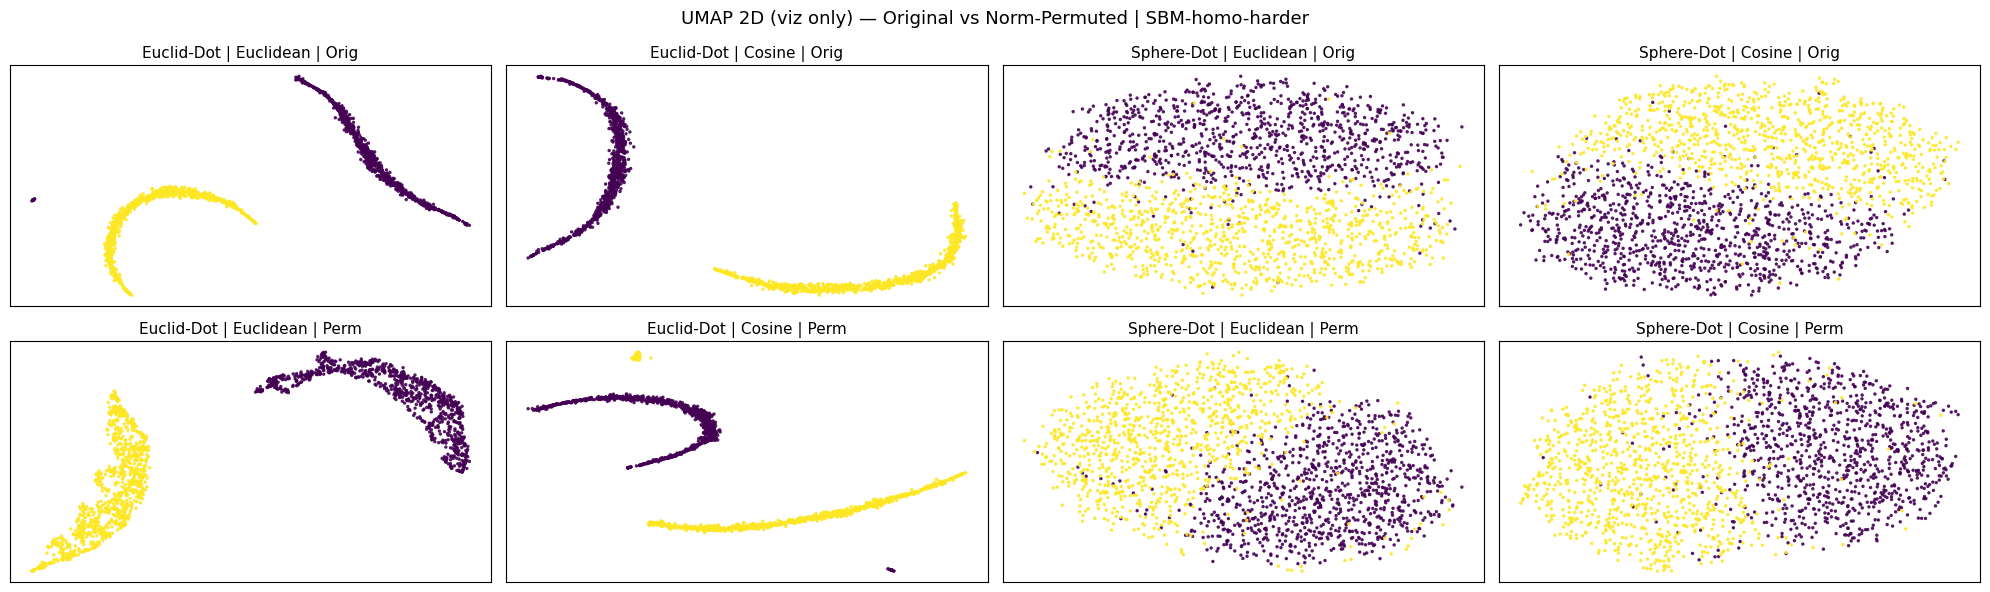

,AMI_dir,AMI_raw,ARI_dir,ARI_raw,ESim_dir,ESim_raw,AMI_dir,AMI_raw,ARI_dir,ARI_raw,ESim_dir,ESim_raw,AMI_dir_Δ,AMI_raw_Δ,ARI_dir_Δ,ARI_raw_Δ,ESim_dir_Δ,ESim_raw_Δ
Config,,,,,,,,,,,,,,,,,,
Euclid-Dot,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Sphere-Dot,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site

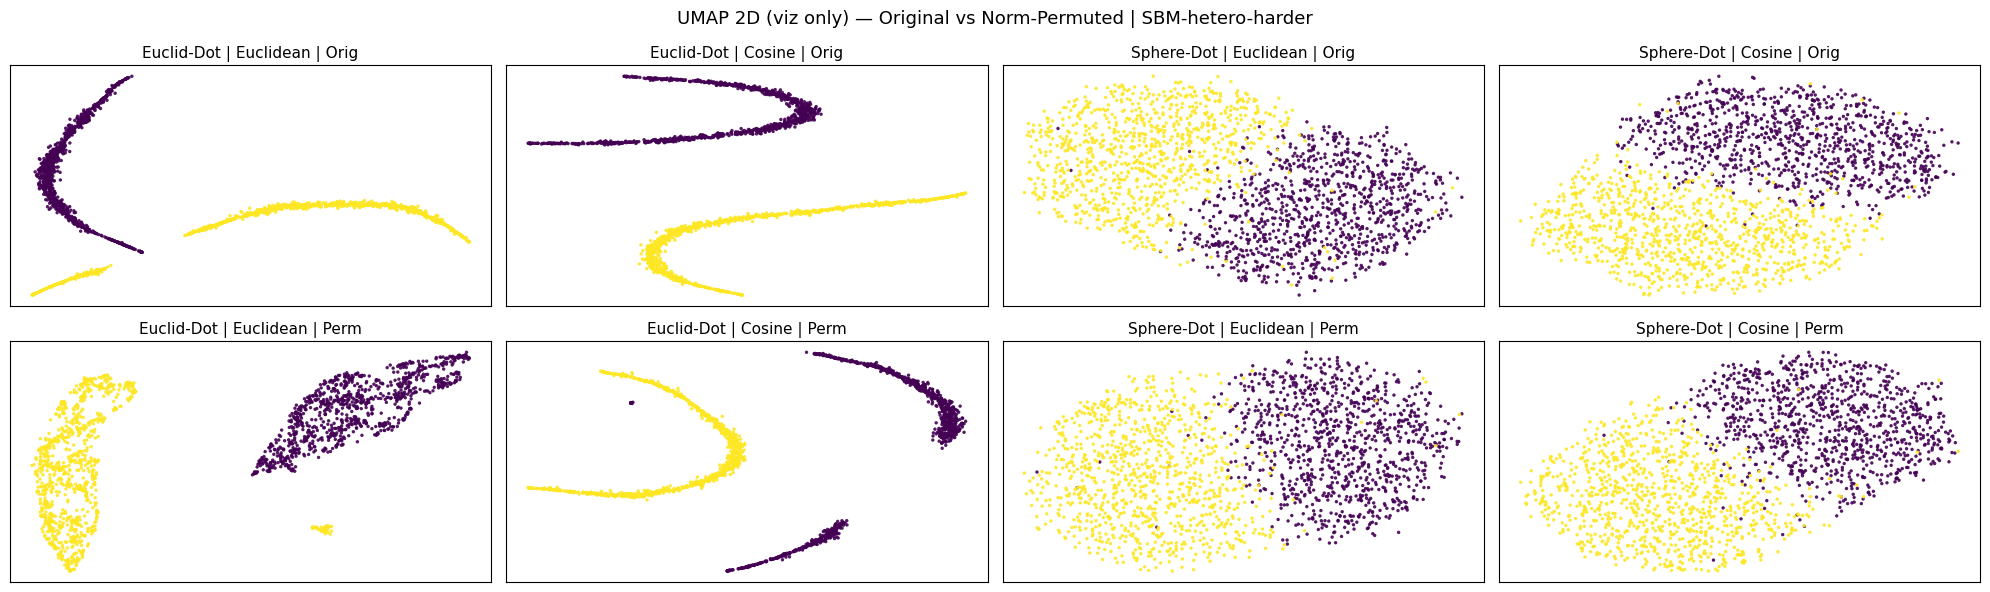

,AMI_dir,AMI_raw,ARI_dir,ARI_raw,ESim_dir,ESim_raw,AMI_dir,AMI_raw,ARI_dir,ARI_raw,ESim_dir,ESim_raw,AMI_dir_Δ,AMI_raw_Δ,ARI_dir_Δ,ARI_raw_Δ,ESim_dir_Δ,ESim_raw_Δ
Config,,,,,,,,,,,,,,,,,,
Euclid-Dot,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Sphere-Dot,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# === Norm permutation analysis: UMAP (viz only) + HIGH-D KMeans/ESim =========
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, scipy.sparse as sp
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import normalize
import umap

OUTDIR = "emb_ckpts_v2"
CONFIG_ORDER = ["Euclid-Dot", "Sphere-Dot"]

# --- ESim (same as before) ---
def calc_esim(y_true, y_pred):
    ylab, y = np.unique(y_true, return_inverse=True)
    plab, p = np.unique(y_pred, return_inverse=True)
    K = max(len(ylab), len(plab)); N = len(y)
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(N), y)), shape=(N, K))
    UB = sp.csr_matrix((np.ones_like(p), (np.arange(N), p)), shape=(N, K))
    nA = np.array(UA.sum(axis=0)).ravel(); nB = np.array(UB.sum(axis=0)).ravel()
    nAB = (UA.T @ UB).toarray(); nAB_rand = np.outer(nA, nB) / max(N,1)
    Q = 1.0 / np.maximum(np.maximum(nA[:,None], 1), np.maximum(1, nB[None,:]))
    S = float(np.sum(Q * (nAB**2)) / max(N,1))
    Srand = float(np.sum(Q * (nAB_rand**2)) / max(N,1))
    return (S - Srand) / (1 - Srand + 1e-12)

# --- helpers ---
def load_U(dataset_name, config, seed=0):
    d = np.load(os.path.join(OUTDIR, f"emb_{dataset_name}_{config}_seed{seed}.npz"))
    return d["U"]

def to_unit_rows(X):
    r = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.clip(r, 1e-12, None), r.squeeze(-1)

def permute_norms_keep_dirs(U, seed=0):
    Uhat, r = to_unit_rows(U)
    rng = np.random.RandomState(seed)
    rperm = r[rng.permutation(len(r))]
    return Uhat * rperm[:, None]

def umap_2d(X, metric="euclidean", n_neighbors=20, min_dist=0.05, seed=42):
    Xp = normalize(X) if metric == "cosine" else X
    reducer = umap.UMAP(
        n_neighbors=n_neighbors, min_dist=min_dist, n_components=2,
        metric=metric, init="random", n_epochs=100
    )
    return reducer.fit_transform(Xp)

# --- HIGH-D clustering metrics (Raw & Dir) ---
def kmeans_metrics_highD(U, y, k=None, seed=0):
    k = k or len(np.unique(y))
    # Raw
    lab_raw = KMeans(n_clusters=k, n_init=20, random_state=seed).fit_predict(U)
    ari_raw = adjusted_rand_score(y, lab_raw)
    ami_raw = adjusted_mutual_info_score(y, lab_raw)
    esim_raw = calc_esim(y, lab_raw)
    # Dir
    Udir, _ = to_unit_rows(U)
    lab_dir = KMeans(n_clusters=k, n_init=20, random_state=seed).fit_predict(Udir)
    ari_dir = adjusted_rand_score(y, lab_dir)
    ami_dir = adjusted_mutual_info_score(y, lab_dir)
    esim_dir = calc_esim(y, lab_dir)
    return dict(ESim_raw=esim_raw, ARI_raw=ari_raw, AMI_raw=ami_raw,
                ESim_dir=esim_dir, ARI_dir=ari_dir, AMI_dir=ami_dir)

def plot_umap_compare_highD(dataset_name, y, seed=0,
                            n_neighbors=20, min_dist=0.05, pointsize=6):
    rows = []
    # layout: rows = {Orig, Perm}, cols = 2 per config (euclid & cosine)
    fig, axes = plt.subplots(2, 2*len(CONFIG_ORDER), figsize=(5*2*len(CONFIG_ORDER), 6),
                             squeeze=False)
    fig.suptitle(f"UMAP 2D (viz only) — Original vs Norm-Permuted | {dataset_name}",
                 y=0.98, fontsize=13)

    col = 0
    for cfg in CONFIG_ORDER:
        U = load_U(dataset_name, cfg, seed=seed)
        Uperm = permute_norms_keep_dirs(U, seed=seed)

        # ---- HIGH-D clustering & metrics (this is what we report) ----
        m_orig = kmeans_metrics_highD(U,     y, seed=seed)
        m_perm = kmeans_metrics_highD(Uperm, y, seed=seed)

        rows.append(dict(Config=cfg, Variant="Orig", **m_orig))
        rows.append(dict(Config=cfg, Variant="Perm", **m_perm))

        # ---- UMAP visualization (no clustering in 2D) ----
        for metric in ["euclidean", "cosine"]:
            Z0 = umap_2d(U,     metric=metric, n_neighbors=n_neighbors, min_dist=min_dist, seed=seed)
            ax = axes[0, col]
            ax.scatter(Z0[:,0], Z0[:,1], c=y, s=pointsize, cmap="viridis", alpha=0.9, linewidths=0)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(f"{cfg} | {metric.capitalize()} | Orig", fontsize=11)

            Z1 = umap_2d(Uperm, metric=metric, n_neighbors=n_neighbors, min_dist=min_dist, seed=seed)
            ax = axes[1, col]
            ax.scatter(Z1[:,0], Z1[:,1], c=y, s=pointsize, cmap="viridis", alpha=0.9, linewidths=0)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(f"{cfg} | {metric.capitalize()} | Perm", fontsize=11)

            col += 1

    plt.tight_layout()
    plt.show()

    # ---- tidy table: Orig vs Perm in HIGH-D (Raw & Dir) ----
    df = pd.DataFrame(rows)
    cols = ["ESim_raw","ARI_raw","AMI_raw","ESim_dir","ARI_dir","AMI_dir"]

    # Guard: ensure we have both variants
    have = set(df["Variant"].unique().tolist())
    if not {"Orig","Perm"}.issubset(have):
        print("[WARN] Missing one of {Orig, Perm} in Variant; returning raw table.")
        display(df)
        return df

    # Pivot to MultiIndex columns: (metric, Variant)
    piv = df.pivot_table(index="Config", columns="Variant", values=cols, aggfunc="mean")
    # Extract by column level
    orig = piv.xs("Orig", level="Variant", axis=1)
    perm = piv.xs("Perm", level="Variant", axis=1)
    delta = (perm - orig).rename(columns=lambda c: f"{c}_Δ")

    out = pd.concat([orig, perm, delta], axis=1).loc[CONFIG_ORDER]
    display(out.round(3))
    return out

# ---- run on both datasets (seed=0 by default) ----
tbl_h_perm = plot_umap_compare_highD("SBM-homo-harder",   y1, seed=0)
tbl_x_perm = plot_umap_compare_highD("SBM-hetero-harder", y2, seed=0)

/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site

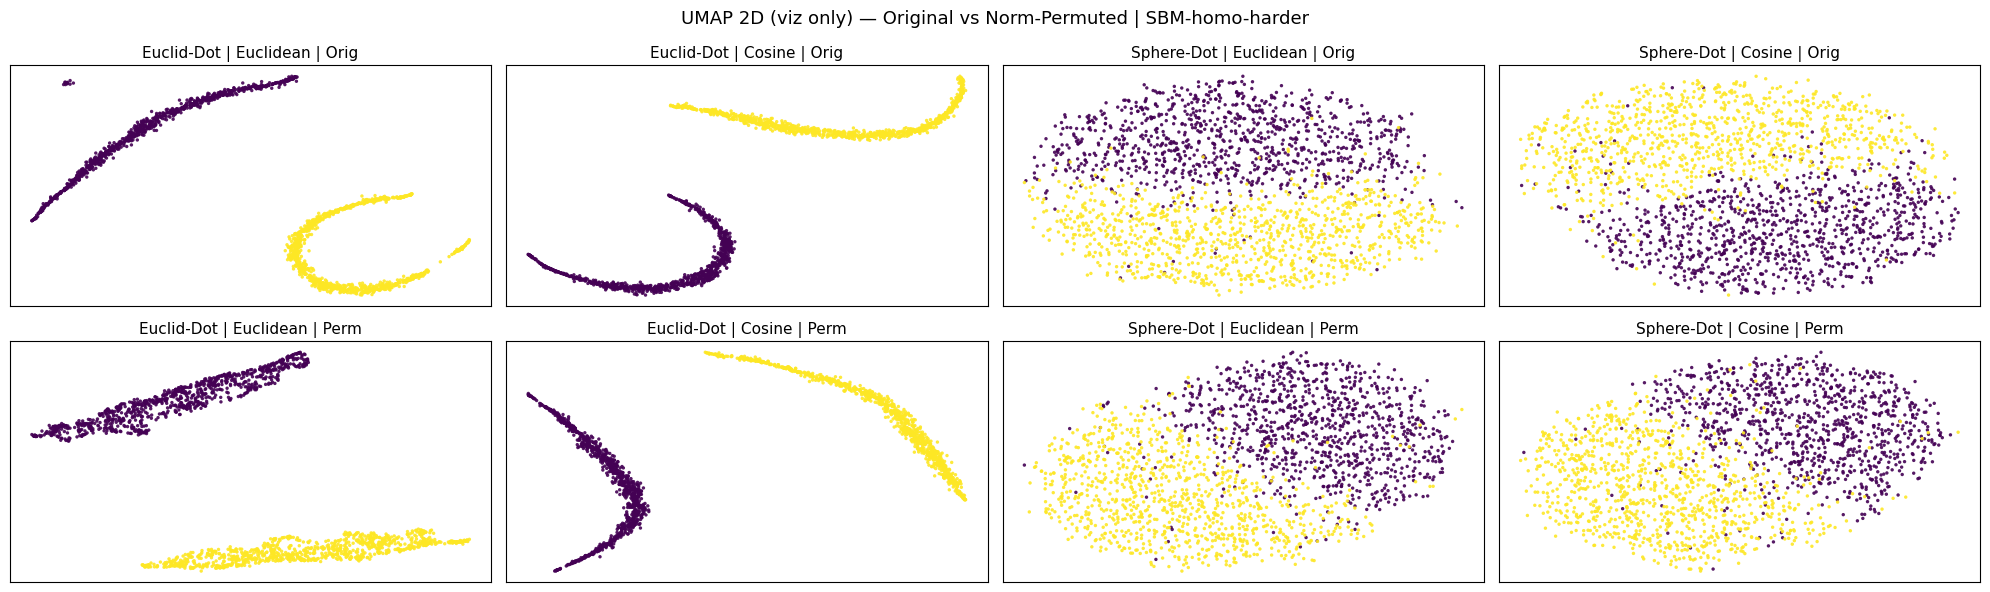

,AMI_dir,AMI_raw,ARI_dir,ARI_raw,ESim_dir,ESim_raw,AMI_dir,AMI_raw,ARI_dir,ARI_raw,ESim_dir,ESim_raw,AMI_dir_Δ,AMI_raw_Δ,ARI_dir_Δ,ARI_raw_Δ,ESim_dir_Δ,ESim_raw_Δ
Config,,,,,,,,,,,,,,,,,,
Euclid-Dot,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Sphere-Dot,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site

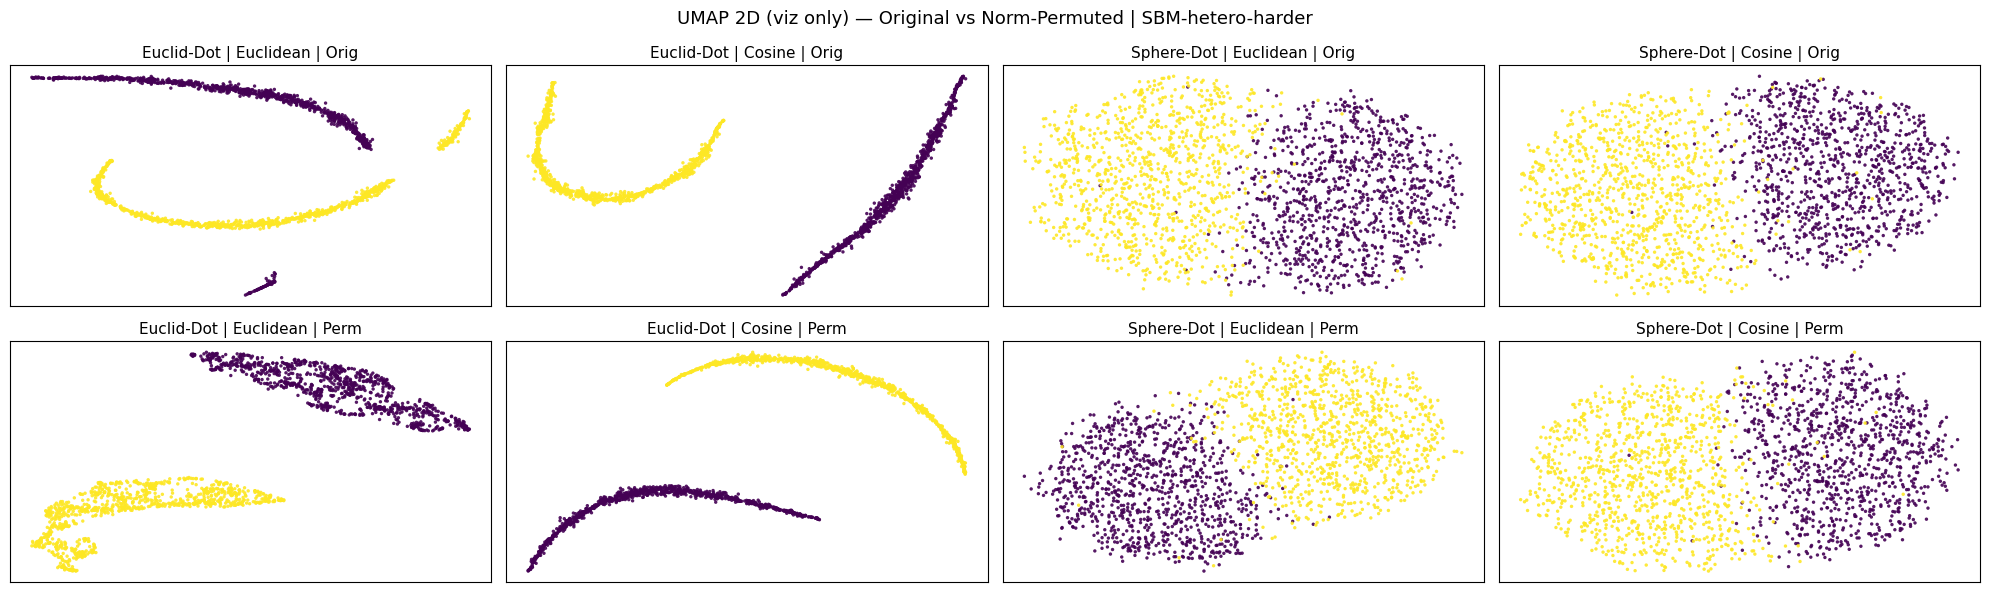

,AMI_dir,AMI_raw,ARI_dir,ARI_raw,ESim_dir,ESim_raw,AMI_dir,AMI_raw,ARI_dir,ARI_raw,ESim_dir,ESim_raw,AMI_dir_Δ,AMI_raw_Δ,ARI_dir_Δ,ARI_raw_Δ,ESim_dir_Δ,ESim_raw_Δ
Config,,,,,,,,,,,,,,,,,,
Euclid-Dot,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Sphere-Dot,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# === B. ANALYZE SAVED RUNS (P1–P4) ===========================================
import os, numpy as np, scipy.sparse as sp, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, adjusted_rand_score, adjusted_mutual_info_score, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

OUTDIR = "emb_ckpts_v2"  # must match training

CONFIG_ORDER = ["Euclid-Dot", "Sphere-Dot"]  # for consistent plotting

# ---------- helpers ----------
def to_unit_rows(X):
    r = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.clip(r, 1e-12, None), r

def degree_vector(A):
    return A.sum(1) if isinstance(A, np.ndarray) else np.asarray(A.sum(axis=1)).ravel()

def load_uv(path_npz):
    d = np.load(path_npz)
    return d["U"], d["V"]

def calc_esim(y_true, y_pred):
    ylab, y = np.unique(y_true, return_inverse=True)
    plab, p = np.unique(y_pred, return_inverse=True)
    K = max(len(ylab), len(plab)); N = len(y)
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(N), y)), shape=(N, K))
    UB = sp.csr_matrix((np.ones_like(p), (np.arange(N), p)), shape=(N, K))
    nA = np.array(UA.sum(axis=0)).ravel(); nB = np.array(UB.sum(axis=0)).ravel()
    nAB = (UA.T @ UB).toarray(); nAB_rand = np.outer(nA, nB) / N
    Q = 1.0 / np.maximum(np.maximum(nA[:,None], 1), np.maximum(1, nB[None,:]))
    S = np.sum(Q * (nAB**2)) / N; Srand = np.sum(Q * (nAB_rand**2)) / N
    return (S - Srand) / max(1e-12, (1 - Srand))

# ---------- P1 ----------
def _fit_logreg_cv(X, y, folds=5, seed=0, C=0.5, max_iter=2000):
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    accs, f1s = [], []
    for tr, te in kf.split(X, y):
        scaler = StandardScaler().fit(X[tr])
        Ztr = scaler.transform(X[tr])
        Zte = scaler.transform(X[te])
        clf = LogisticRegression(solver="lbfgs", max_iter=max_iter, C=C).fit(Ztr, y[tr])
        pred = clf.predict(Zte)
        accs.append(accuracy_score(y[te], pred))
        f1s.append(f1_score(y[te], pred, average="macro"))
    return float(np.mean(accs)), float(np.std(accs)), float(np.mean(f1s)), float(np.std(f1s))

def probe_p1(U, y, folds=5, seed=0):
    Xdir, r = to_unit_rows(U)
    Xnorm  = np.log(np.clip(r, 1e-12, None))
    Xraw   = U
    out = {}
    for name, X in [("dir", Xdir), ("norm", Xnorm), ("dir_plus_norm", np.hstack([Xdir, Xnorm])), ("raw", Xraw)]:
        acc_m, acc_s, f1_m, f1_s = _fit_logreg_cv(X, y, folds=folds, seed=seed)
        out[f"{name}_acc"] = acc_m; out[f"{name}_acc_std"] = acc_s
        out[f"{name}_f1"]  = f1_m; out[f"{name}_f1_std"]  = f1_s
    return out

# ---------- P2 ----------
def probe_p2(U, y, k=2, seed=0):
    km_raw = KMeans(n_clusters=k, n_init=10, random_state=seed).fit(U)
    Xdir, _ = to_unit_rows(U)
    km_dir = KMeans(n_clusters=k, n_init=10, random_state=seed).fit(Xdir)
    res = {}
    for tag, lab in [("raw", km_raw.labels_), ("dir", km_dir.labels_)]:
        res[f"{tag}_ari"]  = adjusted_rand_score(y, lab)
        res[f"{tag}_ami"]  = adjusted_mutual_info_score(y, lab)
        res[f"{tag}_esim"] = calc_esim(y, lab)
    return res

# ---------- P3 (score-consistent, U–V dot; with norm permutation) ----------
def _unit(X): return X / np.clip(np.linalg.norm(X, axis=1, keepdims=True), 1e-12, None)

def _sample_pairs(y, m=40000, seed=0):
    rng = np.random.RandomState(seed)
    n = len(y); I = rng.randint(0,n,size=m); J = rng.randint(0,n,size=m)
    return I, J, (y[I]==y[J]).astype(int)

def probe_p3(U, V, y, seed=0, use_midband=False, band=(0.2,0.6)):
    I, J, same = _sample_pairs(y, m=40000, seed=seed)
    # base AUROC
    s = 0.5*(np.sum(U[I]*V[J],axis=1)+np.sum(U[J]*V[I],axis=1))
    auc = roc_auc_score(same, s)

    # permuted norms (independently on U and V)
    rng = np.random.RandomState(seed)
    rU = np.linalg.norm(U, axis=1); rV = np.linalg.norm(V, axis=1)
    Uperm = _unit(U) * rU[rng.permutation(len(rU))][:,None]
    Vperm = _unit(V) * rV[rng.permutation(len(rV))][:,None]
    sp = 0.5*(np.sum(Uperm[I]*Vperm[J],axis=1)+np.sum(Uperm[J]*Vperm[I],axis=1))
    aucp = roc_auc_score(same, sp)

    out = dict(auc=auc, auc_perm=aucp, auc_drop=auc-aucp)

    if use_midband:
        Ui, Vj = _unit(U[I]), _unit(V[J])
        Uj, Vi = _unit(U[J]), _unit(V[I])
        cosij = 0.5*(np.sum(Ui*Vj,axis=1)+np.sum(Uj*Vi,axis=1))
        mask = (cosij>=band[0]) & (cosij<=band[1])
        if mask.sum() >= 2000:
            out["auc_midband"] = roc_auc_score(same[mask], s[mask])
            out["aucp_midband"] = roc_auc_score(same[mask], sp[mask])
            out["auc_drop_midband"] = out["auc_midband"] - out["aucp_midband"]
        else:
            out["auc_midband"] = np.nan; out["aucp_midband"]=np.nan; out["auc_drop_midband"]=np.nan
    return out

# ---------- P4 ----------
def probe_p4(U, V, A):
    deg = degree_vector(A).astype(float)
    rU = np.linalg.norm(U, axis=1); rV = np.linalg.norm(V, axis=1)
    z = lambda a: (a - a.mean()) / (a.std() + 1e-12)
    return dict(corrU=float(np.mean(z(rU)*z(deg))),
                corrV=float(np.mean(z(rV)*z(deg))))

# ---------- run analysis on saved files ----------
def analyze_dataset(dataset_name, A, y, seeds=range(5), folds=5, use_midband=True):
    rows = []
    for cfg in CONFIG_ORDER:
        for s in seeds:
            path = os.path.join(OUTDIR, f"emb_{dataset_name}_{cfg}_seed{s}.npz")
            if not os.path.exists(path):
                raise FileNotFoundError(path)
            U, V = load_uv(path)
            p1 = probe_p1(U, y, folds=folds, seed=s)
            p2 = probe_p2(U, y, k=len(np.unique(y)), seed=s)
            p3 = probe_p3(U, V, y, seed=s, use_midband=use_midband)
            p4 = probe_p4(U, V, A)
            rows.append({"dataset":dataset_name, "config":cfg, "seed":s, **{f"P1_{k}":v for k,v in p1.items()},
                         **{f"P2_{k}":v for k,v in p2.items()}, **{f"P3_{k}":v for k,v in p3.items()},
                         **{f"P4_{k}":v for k,v in p4.items()}})
    df = pd.DataFrame(rows)
    return df

# If you kept A1,y1 and A2,y2 in memory from training cell, reuse them.
# If not, rebuild them with the same functions/params used in training:
try:
    A1, y1
except NameError:
    from __main__ import sbm_balanced, sbm_hetero
    A1, y1 = sbm_balanced()
    A2, y2 = sbm_hetero()

df_h = analyze_dataset("SBM-homo-harder",   A1, y1, seeds=range(1))
df_x = analyze_dataset("SBM-hetero-harder", A2, y2, seeds=range(1))
DF = pd.concat([df_h, df_x], ignore_index=True)
print("[OK] analysis complete; DF.shape =", DF.shape)

[OK] analysis complete; DF.shape = (4, 33)


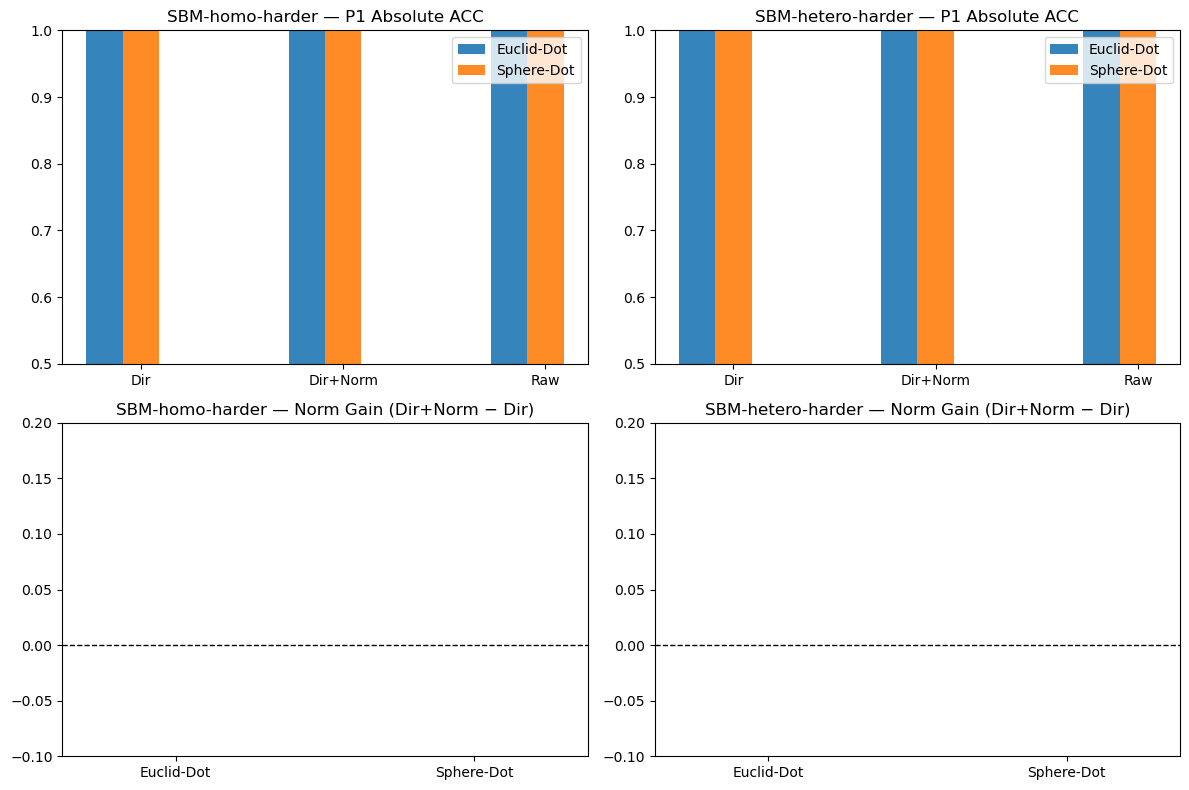

=== SBM-homo-harder ===
Euclid-Dot  | P1 Dir 1.000  Dir+Norm 1.000  Raw 1.000 | P3 AUC 0.857  Δperm +0.003 | P4 corr(‖U‖,deg) -0.079
Sphere-Dot  | P1 Dir 1.000  Dir+Norm 1.000  Raw 1.000 | P3 AUC 0.888  Δperm +0.000 | P4 corr(‖U‖,deg) +0.005
=== SBM-hetero-harder ===
Euclid-Dot  | P1 Dir 1.000  Dir+Norm 1.000  Raw 1.000 | P3 AUC 0.934  Δperm +0.012 | P4 corr(‖U‖,deg) +0.257
Sphere-Dot  | P1 Dir 1.000  Dir+Norm 1.000  Raw 1.000 | P3 AUC 0.920  Δperm -0.000 | P4 corr(‖U‖,deg) -0.020


In [26]:
# === C. PLOTS ================================================================
import numpy as np, matplotlib.pyplot as plt

def plot_p1_absolute_and_gain(df, dataset_names):
    fig, axes = plt.subplots(2, len(dataset_names), figsize=(6*len(dataset_names), 8), squeeze=False)
    for j, ds in enumerate(dataset_names):
        sub = df[df["dataset"]==ds]
        # Absolute ACC
        ax = axes[0, j]
        for i, tag in enumerate(CONFIG_ORDER):
            dtag = sub[sub["config"]==tag]
            xs = np.array([0,1,2]) + 0.18*i
            means = [dtag["P1_dir_acc"].mean(), dtag["P1_dir_plus_norm_acc"].mean(), dtag["P1_raw_acc"].mean()]
            stds  = [dtag["P1_dir_acc"].std(),  dtag["P1_dir_plus_norm_acc"].std(),  dtag["P1_raw_acc"].std()]
            ax.bar(xs, means, yerr=stds, width=0.18, alpha=0.9, label=tag)
        ax.set_xticks([0.18, 1.18, 2.18]); ax.set_xticklabels(["Dir","Dir+Norm","Raw"])
        ax.set_ylim(0.5, 1.0); ax.set_title(f"{ds} — P1 Absolute ACC"); ax.legend()

        # Norm gain
        ax = axes[1, j]
        for i, tag in enumerate(CONFIG_ORDER):
            dtag = sub[sub["config"]==tag]
            gain = (dtag["P1_dir_plus_norm_acc"] - dtag["P1_dir_acc"]).values
            ax.bar(i, np.mean(gain), yerr=np.std(gain), width=0.6, alpha=0.9, label=tag)
        ax.set_xticks(range(len(CONFIG_ORDER))); ax.set_xticklabels(CONFIG_ORDER)
        ax.set_ylim(-0.1, 0.2); ax.axhline(0, ls="--", lw=1, c="k")
        ax.set_title(f"{ds} — Norm Gain (Dir+Norm − Dir)")
    plt.tight_layout(); plt.show()

def brief(df, dataset_name):
    print(f"=== {dataset_name} ===")
    for tag in CONFIG_ORDER:
        sub = df[(df["dataset"]==dataset_name) & (df["config"]==tag)]
        print(f"{tag:11s} | P1 Dir {sub['P1_dir_acc'].mean():.3f}  Dir+Norm {sub['P1_dir_plus_norm_acc'].mean():.3f}  Raw {sub['P1_raw_acc'].mean():.3f} | "
              f"P3 AUC {sub['P3_auc'].mean():.3f}  Δperm {sub['P3_auc_drop'].mean():+.3f} | "
              f"P4 corr(‖U‖,deg) {sub['P4_corrU'].mean():+.3f}")

plot_p1_absolute_and_gain(DF, ["SBM-homo-harder","SBM-hetero-harder"])
brief(DF, "SBM-homo-harder")
brief(DF, "SBM-hetero-harder")

/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


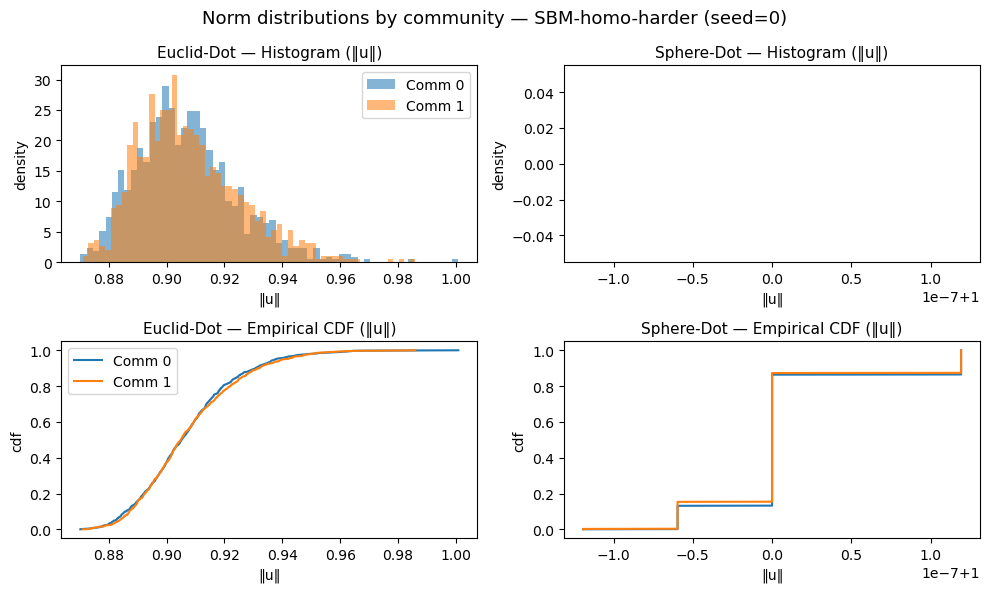

,dataset,config,mean0,std0,mean1,std1,cohens_d,ks_stat,ks_p,corr_norm_deg
0,SBM-homo-harder,Euclid-Dot,0.906976,1.751634e-02,0.907636,1.771716e-02,0.03746,0.034,0.610166,-0.080383
1,SBM-homo-harder,Sphere-Dot,1.000000,4.913967e-08,1.000000,4.884933e-08,0.00000,0.022,0.969001,-0.006769


/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


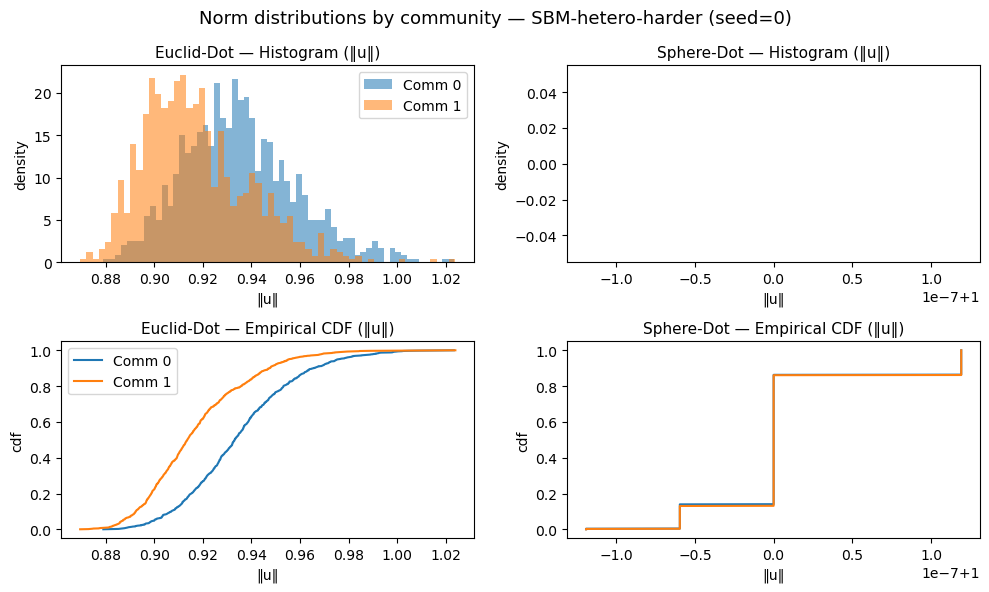

,dataset,config,mean0,std0,mean1,std1,cohens_d,ks_stat,ks_p,corr_norm_deg
0,SBM-hetero-harder,Euclid-Dot,0.934998,2.311159e-02,0.917096,2.166321e-02,-0.799237,0.364,2.794837e-59,0.255020
1,SBM-hetero-harder,Sphere-Dot,1.000000,4.989378e-08,1.000000,4.975102e-08,0.000000,0.009,1.000000e+00,-0.021406


In [35]:
# === Make embeddings easily accessible + plot norm distributions per community ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, scipy.sparse as sp
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import normalize
from scipy.stats import ks_2samp
import umap

# Reuse these from your notebook:
# OUTDIR = "emb_ckpts_v2"
# CONFIG_ORDER = ["Euclid-Dot", "Sphere-Dot"]

# ---------- cache ----------
EMB = {}   # keys: (dataset_name, config, seed) -> U (np.ndarray)

def load_U(dataset_name, config, seed=0):
    d = np.load(os.path.join(OUTDIR, f"emb_{dataset_name}_{config}_seed{seed}.npz"))
    return d["U"]

def get_U(dataset_name, config, seed=0, reload=False):
    key = (dataset_name, config, seed)
    if (not reload) and key in EMB:
        return EMB[key]
    U = load_U(dataset_name, config, seed=seed)
    EMB[key] = U
    return U

def to_unit_rows(X):
    r = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.clip(r, 1e-12, None), r.squeeze(-1)

# ---------- ESim (unchanged) ----------
def calc_esim(y_true, y_pred):
    ylab, y = np.unique(y_true, return_inverse=True)
    plab, p = np.unique(y_pred, return_inverse=True)
    K = max(len(ylab), len(plab)); N = len(y)
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(N), y)), shape=(N, K))
    UB = sp.csr_matrix((np.ones_like(p), (np.arange(N), p)), shape=(N, K))
    nA = np.array(UA.sum(axis=0)).ravel(); nB = np.array(UB.sum(axis=0)).ravel()
    nAB = (UA.T @ UB).toarray(); nAB_rand = np.outer(nA, nB) / max(N,1)
    Q = 1.0 / np.maximum(np.maximum(nA[:,None], 1), np.maximum(1, nB[None,:]))
    S = float(np.sum(Q * (nAB**2)) / max(N,1))
    Srand = float(np.sum(Q * (nAB_rand**2)) / max(N,1))
    return (S - Srand) / (1 - Srand + 1e-12)

# ---------- High-D clustering metrics (raw & dir) ----------
def metrics_highD(U, y, k=None, seed=0):
    from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
    k = k or len(np.unique(y))
    # Raw
    lab_raw = KMeans(n_clusters=k, n_init=20, random_state=seed).fit_predict(U)
    ari_raw = adjusted_rand_score(y, lab_raw)
    ami_raw = adjusted_mutual_info_score(y, lab_raw)
    esim_raw = calc_esim(y, lab_raw)
    # Dir
    Udir, _ = to_unit_rows(U)
    lab_dir = KMeans(n_clusters=k, n_init=20, random_state=seed).fit_predict(Udir)
    ari_dir = adjusted_rand_score(y, lab_dir)
    ami_dir = adjusted_mutual_info_score(y, lab_dir)
    esim_dir = calc_esim(y, lab_dir)
    return dict(ARI_raw=ari_raw, AMI_raw=ami_raw, ESim_raw=esim_raw,
                ARI_dir=ari_dir, AMI_dir=ami_dir, ESim_dir=esim_dir)

 
# ---------- NEW: Norm distributions per community ----------
def degree_vector(A):
    return A.sum(1) if isinstance(A, np.ndarray) else np.asarray(A.sum(axis=1)).ravel()

def plot_norms_by_community(dataset_name, y, seed=0, A=None, bins=60):
    """
    For each config, overlay histograms & CDFs of ||u|| per community,
    plus summary stats (mean, std, Cohen's d, KS p). If A is given, print corr(||u||, deg).
    """
    Ks = len(np.unique(y))
    assert Ks == 2, "This helper expects 2 communities for overlay. Extend if needed."

    fig, axes = plt.subplots(2, len(CONFIG_ORDER), figsize=(5*len(CONFIG_ORDER), 6), squeeze=False)
    fig.suptitle(f"Norm distributions by community — {dataset_name} (seed={seed})", y=0.98, fontsize=13)
    summary = []

    for j, cfg in enumerate(CONFIG_ORDER):
        U = get_U(dataset_name, cfg, seed=seed)
        r = np.linalg.norm(U, axis=1)
        g0 = (y == np.unique(y)[0]); g1 = ~g0

        # Hist (pdf-like)
        ax = axes[0, j]
        ax.hist(r[g0], bins=bins, density=True, alpha=0.55, label="Comm 0")
        ax.hist(r[g1], bins=bins, density=True, alpha=0.55, label="Comm 1")
        ax.set_title(f"{cfg} — Histogram (‖u‖)", fontsize=11)
        ax.set_xlabel("‖u‖"); ax.set_ylabel("density")
        if j == 0: ax.legend()

        # CDF
        ax = axes[1, j]
        for mask, lab in [(g0, "Comm 0"), (g1, "Comm 1")]:
            rv = np.sort(r[mask]); cdf = np.arange(1, rv.size+1)/rv.size
            ax.plot(rv, cdf, label=lab)
        ax.set_title(f"{cfg} — Empirical CDF (‖u‖)", fontsize=11)
        ax.set_xlabel("‖u‖"); ax.set_ylabel("cdf")
        if j == 0: ax.legend()

        # Stats
        m0, s0 = float(r[g0].mean()), float(r[g0].std(ddof=1))
        m1, s1 = float(r[g1].mean()), float(r[g1].std(ddof=1))
        pooled = np.sqrt(((s0**2) + (s1**2)) / 2.0 + 1e-12)
        d = (m1 - m0) / pooled
        ks_stat, ks_p = ks_2samp(r[g0], r[g1])

        row = dict(dataset=dataset_name, config=cfg,
                   mean0=m0, std0=s0, mean1=m1, std1=s1,
                   cohens_d=d, ks_stat=ks_stat, ks_p=ks_p)

        if A is not None:
            deg = degree_vector(A).astype(float)
            z = lambda x: (x - x.mean()) / (x.std() + 1e-12)
            corr = float(np.mean(z(r) * z(deg)))
            row["corr_norm_deg"] = corr

        summary.append(row)

    plt.tight_layout(); plt.show()
    df_sum = pd.DataFrame(summary)
    display(df_sum)
    return df_sum

# ---- Run: UMAP + HD table (unchanged), then Norm plots (embeddings come from cache) ----
# tbl_h = plot_umaps_with_hd_table("SBM-homo-harder",   y1, seed=0)
# tbl_x = plot_umaps_with_hd_table("SBM-hetero-harder", y2, seed=0)

# If you still have A1/A2 in scope, pass them to get corr(||u||,deg)
_ = plot_norms_by_community("SBM-homo-harder",   y1, seed=0, A=A1)
_ = plot_norms_by_community("SBM-hetero-harder", y2, seed=0, A=A2)
